In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
import pandas as pd

healthy_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/normal',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Normal',
    r'/kaggle/input/osteoporosis/osteoporosis/normal'
]

osteoporosis_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Osteoporosis',
    r'/kaggle/input/osteoporosis/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']


for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)

print(knee_osteoporosis_data.head())
print(knee_osteoporosis_data["labels"].value_counts())

                                           filepaths   labels
0  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
1  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
2  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
3  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
4  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
labels
Osteoporosis    793
Healthy         780
Name: count, dtype: int64


In [4]:
knee_osteoporosis_data.shape

(1573, 2)

In [5]:
 

train_data, remaining_data = train_test_split(knee_osteoporosis_data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

In [6]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1258, 2)
(157, 2)
(158, 2)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_data,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_data,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_data,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1258 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.


In [8]:

classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [9]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))

    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        # Menambahkan judul dengan nama kelas
        index=np.argmax(labels[i]) 
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

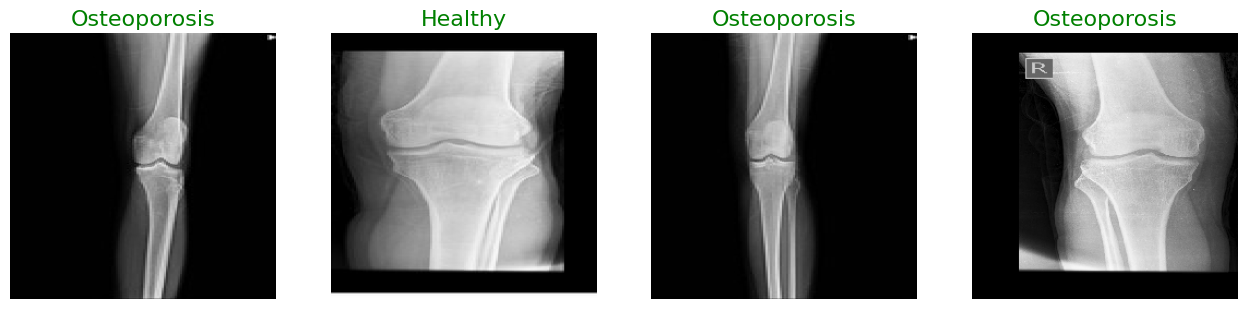

In [10]:
show_knee_images(train)

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization
from keras.models import Model
from keras.applications import DenseNet121

import tensorflow as tf

densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the custom model by adding layers
x = densenet_model.output

# Add your custom layers according to your specified architecture
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.5)(x) 
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.5)(x) 
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)

output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model = Model(inputs=densenet_model.input, outputs=output)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()


29084464/29084464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [12]:
history = model.fit(train, epochs=15, validation_data=val, verbose=1)

Epoch 1/15


2025-01-22 14:25:20.716621: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


315/315 [==============================] - 114s 139ms/step - loss: 0.6932 - accuracy: 0.4913 - val_loss: 0.6932 - val_accuracy: 0.4557
Epoch 2/15
315/315 [==============================] - 30s 95ms/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 0.6934 - val_accuracy: 0.4557
Epoch 3/15
315/315 [==============================] - 30s 96ms/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 0.6934 - val_accuracy: 0.4557
Epoch 4/15
315/315 [==============================] - 29s 94ms/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 0.6936 - val_accuracy: 0.4557
Epoch 5/15
315/315 [==============================] - 30s 94ms/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 0.6938 - val_accuracy: 0.4557
Epoch 6/15
315/315 [==============================] - 30s 94ms/step - loss: 0.6266 - accuracy: 0.6256 - val_loss: 0.4551 - val_accuracy: 0.8608
Epoch 7/15
315/315 [==============================] - 30s 95ms/step - loss: 0.3625 - accuracy: 0.8688 - val_loss: 0.3332 - val_accuracy: 0.8797
E

In [13]:
history1 = model.fit(train, epochs=15, validation_data=val, verbose=1)

Epoch 1/15
315/315 [==============================] - 30s 94ms/step - loss: 0.0392 - accuracy: 0.9913 - val_loss: 0.3280 - val_accuracy: 0.9114
Epoch 2/15
315/315 [==============================] - 30s 94ms/step - loss: 0.0336 - accuracy: 0.9913 - val_loss: 0.2244 - val_accuracy: 0.9367
Epoch 3/15
315/315 [==============================] - 30s 94ms/step - loss: 0.0309 - accuracy: 0.9944 - val_loss: 0.2523 - val_accuracy: 0.9241
Epoch 4/15
315/315 [==============================] - 29s 93ms/step - loss: 0.0206 - accuracy: 0.9928 - val_loss: 0.4351 - val_accuracy: 0.9177
Epoch 5/15
315/315 [==============================] - 30s 94ms/step - loss: 0.0091 - accuracy: 0.9960 - val_loss: 0.4476 - val_accuracy: 0.9177
Epoch 6/15
315/315 [==============================] - 30s 94ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.3737 - val_accuracy: 0.9304
Epoch 7/15
315/315 [==============================] - 29s 93ms/step - loss: 6.0804e-04 - accuracy: 1.0000 - val_loss: 0.4777 - val_accur

In [14]:
model.evaluate(test, verbose=1)

40/40 [==============================] - 5s 118ms/step - loss: 0.7072 - accuracy: 0.9299


[0.707207441329956, 0.9299362897872925]

In [15]:
history2 = model.fit(train, epochs=15, validation_data=val, verbose=1)

Epoch 1/15
315/315 [==============================] - 30s 94ms/step - loss: 2.4766e-06 - accuracy: 1.0000 - val_loss: 0.9012 - val_accuracy: 0.9304
Epoch 2/15
315/315 [==============================] - 30s 94ms/step - loss: 1.9504e-06 - accuracy: 1.0000 - val_loss: 0.9565 - val_accuracy: 0.9241
Epoch 3/15
315/315 [==============================] - 30s 93ms/step - loss: 1.7853e-06 - accuracy: 1.0000 - val_loss: 0.9472 - val_accuracy: 0.9304
Epoch 4/15
315/315 [==============================] - 29s 93ms/step - loss: 1.4554e-06 - accuracy: 1.0000 - val_loss: 0.9875 - val_accuracy: 0.9304
Epoch 5/15
315/315 [==============================] - 29s 93ms/step - loss: 8.8712e-07 - accuracy: 1.0000 - val_loss: 1.0485 - val_accuracy: 0.9241
Epoch 6/15
315/315 [==============================] - 29s 93ms/step - loss: 4.7541e-07 - accuracy: 1.0000 - val_loss: 1.0804 - val_accuracy: 0.9304
Epoch 7/15
315/315 [==============================] - 29s 93ms/step - loss: 6.0189e-07 - accuracy: 1.0000 - val_

In [16]:
model.evaluate(test, verbose=1)

40/40 [==============================] - 2s 51ms/step - loss: 1.0182 - accuracy: 0.9299


[1.0182251930236816, 0.9299362897872925]

In [17]:
history3 = model.fit(train, epochs=15, validation_data=val, verbose=1)

Epoch 1/15
315/315 [==============================] - 30s 94ms/step - loss: 9.6182e-08 - accuracy: 1.0000 - val_loss: 1.2919 - val_accuracy: 0.9241
Epoch 2/15
315/315 [==============================] - 29s 93ms/step - loss: 8.6137e-08 - accuracy: 1.0000 - val_loss: 1.2635 - val_accuracy: 0.9241
Epoch 3/15
315/315 [==============================] - 29s 93ms/step - loss: 8.2347e-08 - accuracy: 1.0000 - val_loss: 1.3627 - val_accuracy: 0.9177
Epoch 4/15
315/315 [==============================] - 29s 94ms/step - loss: 8.5094e-08 - accuracy: 1.0000 - val_loss: 1.3824 - val_accuracy: 0.9241
Epoch 5/15
315/315 [==============================] - 29s 93ms/step - loss: 6.6048e-08 - accuracy: 1.0000 - val_loss: 1.4047 - val_accuracy: 0.9241
Epoch 6/15
315/315 [==============================] - 30s 94ms/step - loss: 7.1354e-08 - accuracy: 1.0000 - val_loss: 1.3163 - val_accuracy: 0.9241
Epoch 7/15
315/315 [==============================] - 30s 95ms/step - loss: 3.2787e-08 - accuracy: 1.0000 - val_

In [18]:
model.evaluate(test, verbose=1)

40/40 [==============================] - 2s 51ms/step - loss: 1.1565 - accuracy: 0.9299


[1.1564728021621704, 0.9299362897872925]

In [19]:
model.save("Osteoporosis_Model_binary.h5")

In [20]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

40/40 [==============================] - 4s 50ms/step


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

y_test = test_data.labels # set y_test to the expected output
print(classification_report(y_test, pred2, digits=5))
print("Accuracy of the Model: {:.5f}".format(accuracy_score(y_test, pred2)))
precision = precision_score(y_test, pred2, average='weighted')
print("Precision of the Model: {:.5f}".format(precision))
recall = recall_score(y_test, pred2, average='weighted')
print("Recall Score of the Model: {:.5f}".format(recall))
f1 = f1_score(y_test, pred2, average='weighted')
print("f1 Score of the Model: {:.5f}".format(f1))

              precision    recall  f1-score   support

     Healthy    0.95946   0.89873   0.92810        79
Osteoporosis    0.90361   0.96154   0.93168        78

    accuracy                        0.92994       157
   macro avg    0.93154   0.93014   0.92989       157
weighted avg    0.93171   0.92994   0.92988       157

Accuracy of the Model: 0.92994
Precision of the Model: 0.93171
Recall Score of the Model: 0.92994
f1 Score of the Model: 0.92988


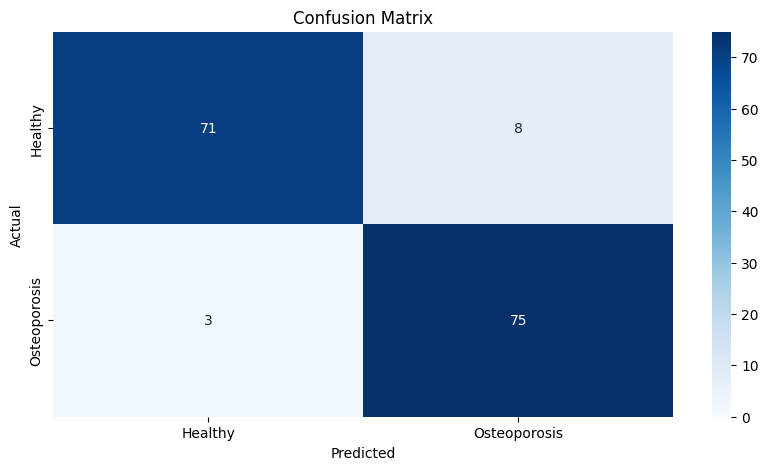

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Healthy','Osteoporosis']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

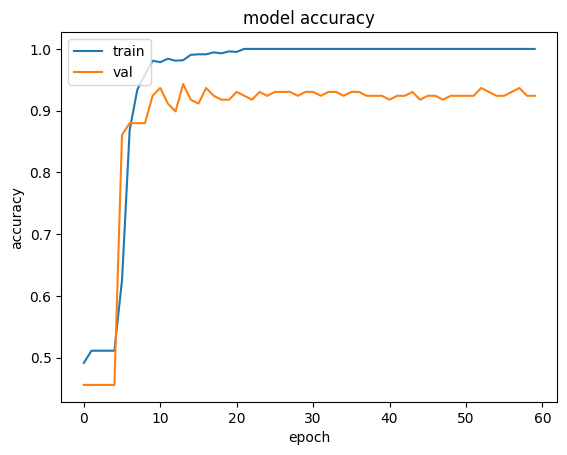

In [23]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

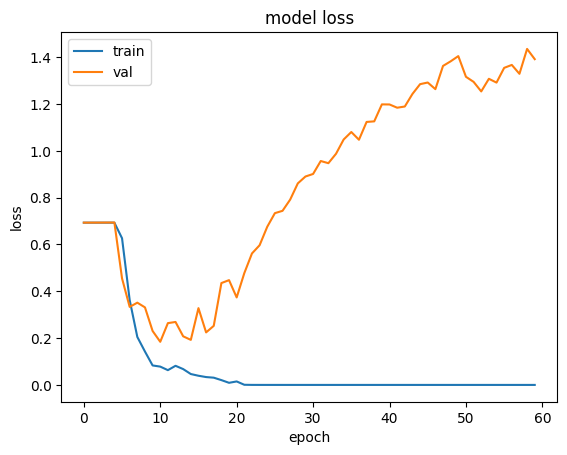

In [24]:
plt.plot(history.history['loss'] + history1.history['loss'] + history2.history['loss'] + history3.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [1]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/kaggle/input/binary/tensorflow2/default/1/Osteoporosis_Model_binary.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [2]:
import os
image_path = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis/OS31.jpg'



In [3]:
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)  # Read the image
    image_resized = cv2.resize(image, target_size)  # Resize the image
    image_normalized = image_resized / 255.0  # Normalize pixel values
    return np.expand_dims(image_normalized, axis=0)  # Add batch dimension


In [4]:
image_path = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis/OS31.jpg'

try:
    # Preprocess the image
    image_ready = preprocess_image(image_path)
    
    # Run prediction
    prediction = model.predict(image_ready)
    
    # Store the result
    results = [{'Filename': os.path.basename(image_path), 'Prediction': prediction[0]}]
    print(results)
except Exception as e:
    print(f"Error processing the image: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[{'Filename': 'OS31.jpg', 'Prediction': array([0.9987142 , 0.00128575], dtype=float32)}]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


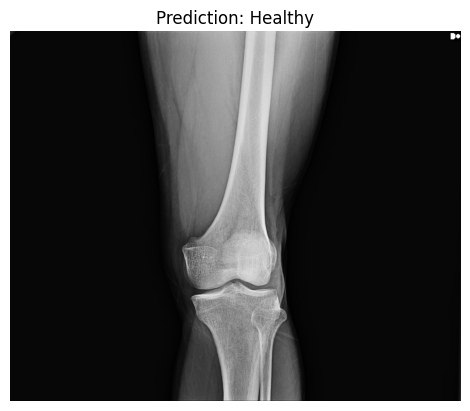

In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Define class labels (adjust based on your model's classes)
class_labels = ["Healthy", "Osteoporosis"]  # Modify as needed

# Attempt to read the image
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Unable to load the image at {image_path}")
else:
    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocess the image (if not already done in the pipeline)
    image_ready = preprocess_image(image_path)  # Ensure this function is defined

    # Run the prediction
    prediction = model.predict(image_ready)

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)  # Use argmax for multiclass models
    predicted_class = class_labels[predicted_class_index]

    # Display the image with the predicted class
    plt.imshow(image_rgb)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()


In [6]:
import pandas as pd

# Example: Store filename and prediction
results = [{'Filename': 'image.jpg', 'Prediction': prediction[0][0]}]  # Adjust as per model output
results_df = pd.DataFrame(results)
results_df.to_csv('/kaggle/working/predictions.csv', index=False)